In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import astropy
from astropy import constants as ac
#from astroquery.mast import Observations
import lightkurve
import celerite
from celerite import terms
from scipy.optimize import minimize
from astropy.io import fits
from astropy.table import Table

In [2]:
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20
rcParams["figure.figsize"] = [8, 5]
rcParams["font.family"] = "sans - serif"
rcParams["font.sans-serif"] = ["Verdana"]
rcParams["text.usetex"] = True


### Kepler Flares

In [3]:
#2014 Flares List

flare_table=pd.read_csv('https://raw.githubusercontent.com/jradavenport/GJ1243-Flares/master/data/gj1243_master_flares.tbl',
            skiprows=23,delim_whitespace=True,names=['index of flare start in "gj1243_master_slc.dat"',
                                                   'index of flare stop in "gj1243_master_slc.dat"','t_start','t_stop'
                                                   ,'t_peak','t_rise','t_decay','flux peak',
                                                   'ED','Duration of rise',
                                                   'Duration of decay','Complex flag',
                                                   '# of people that identified flare event exists',
                                                   '# of people that analyzed this month',
                                                   '# of flare template components fit to event'])
t_starts=flare_table.loc[:,'t_start']
t_stops=flare_table.loc[:,'t_stop']
flux_peak = flare_table.loc[:,'flux peak'].values
complex_flag = flare_table['Complex flag'] #2=complex, 1 = classical
ED = flare_table['ED'] #units=seconds
flare_table['Flare_Duration'] = 1440.*(t_stops-t_starts) #units = minutes

### TESS Flares

In [4]:
#Importing in all of the TESS FLARES (classical/complex) 132
tess_flares= pd.read_csv('/Users/lupitatovar/TESS/all_tess_flares.txt',delim_whitespace=True,comment='#',names = ['Event_ID', 'Start_INDX', 'Stop_INDX', 't_peak', 't_start', 't_stop', 't_rise', 't_decay', 
            'Flux_peak', 'Equiv_Dur', 'S/N', 'CPLX_flg', 'MLTPK_flg', 'MLTPK_num', 't_MLTPK', 'L_mltpk', 
            'MLTPK_INDX', 'quies','x'])[1:]
tess_t_starts = tess_flares.loc[:,'t_start'].values
tess_t_stops = tess_flares.loc[:,'t_stop'].values
flux_peak = tess_flares.loc[:,'Flux_peak'].values
t_complex_flag = tess_flares.loc[:,'CPLX_flg'].values
tess_flares['Flare_Duration'] = 1440.*(tess_t_stops-tess_t_starts)


#secotr 41
tess_flares41= pd.read_csv('/Users/lupitatovar/local_flares/final_flare_lists/TESS/tesss41.dat.fbeye',delim_whitespace=True,comment='#',names = ['Event_ID', 'Start_INDX', 'Stop_INDX', 't_peak', 't_start', 't_stop', 't_rise', 't_decay', 
            'Flux_peak', 'Equiv_Dur', 'S/N', 'CPLX_flg', 'MLTPK_flg', 'MLTPK_num', 't_MLTPK', 'L_mltpk', 
            'MLTPK_INDX', 'quies','x'])[1:]
tess_flares41['Flare_Duration'] = 1440.*(tess_flares41.loc[:,'t_stop'].values-tess_flares41.loc[:,'t_start'].values)

combining all the tess flares including s41

In [7]:
#combining all the tess flares including s41
frames = [tess_flares,tess_flares41]
full_tess = pd.concat(frames)
#full_tess

In [28]:
full_tess

,Event_ID,Start_INDX,Stop_INDX,t_peak,t_start,t_stop,t_rise,t_decay,Flux_peak,Equiv_Dur,S/N,CPLX_flg,MLTPK_flg,MLTPK_num,t_MLTPK,L_mltpk,MLTPK_INDX,quies,x,Flare_Duration
1,2,332.0,336.0,1683.831182,1683.828405,1683.833960,0.002778,0.002778,0.004359,1.039416,0.856315,4.0,0.0,0.0,0.0,0.0,0.0,11337.21094,;,8.000106
2,3,618.0,622.0,1684.233965,1684.232576,1684.238132,0.001389,0.004167,0.004396,1.021397,0.698504,4.0,0.0,0.0,0.0,0.0,0.0,11377.51562,;,8.000103
3,4,676.0,685.0,1684.315911,1684.313133,1684.325633,0.002778,0.009722,0.011388,4.056827,1.721060,4.0,0.0,0.0,0.0,0.0,0.0,11337.41602,;,18.000231
4,5,1619.0,1628.0,1685.624261,1685.622872,1685.635372,0.001389,0.011111,0.007767,2.732755,1.365432,4.0,0.0,0.0,0.0,0.0,0.0,11342.76758,;,18.000222
5,6,1655.0,1661.0,1685.674261,1685.672872,1685.681206,0.001389,0.006945,0.006291,1.887355,1.065632,4.0,0.0,0.0,0.0,0.0,0.0,11338.58984,;,12.000148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47,57,10134.0,10142.0,2435.203239,2435.197683,2435.208794,0.005556,0.005556,0.004420,1.816458,1.095057,4.0,0.0,0.0,0.0,0.0,0.0,11302.00879,;,15.999987
48,58,10750.0,10849.0,2436.058794,2436.054627,2436.192127,0.004167,0.133333,0.039386,127.881465,10.561373,1.0,0.0,0.0,0.0,0.0,0.0,11299.08105,;,197.999829
49,59,11061.0,11084.0,2436.492127,2436.486571,2436.518515,0.005556,0.026389,0.011841,8.704707,2.393503,2.0,0.0,0.0,0.0,0.0,0.0,11317.58105,;,45.999958
50,60,13780.0,13797.0,2440.281011,2440.272677,2440.296288,0.008333,0.015278,0.006244,3.916223,1.463201,1.0,0.0,0.0,0.0,0.0,0.0,11324.44336,;,33.999943


### Loading in the gp + detrended lightcurves

Kepler

0 (46806, 7)
1 (42289, 7)
2 (32946, 7)
3 (39984, 7)
4 (44060, 7)
5 (34037, 7)
6 (45254, 7)
7 (39630, 7)
8 (43978, 7)
9 (45006, 7)
10 (39121, 7)


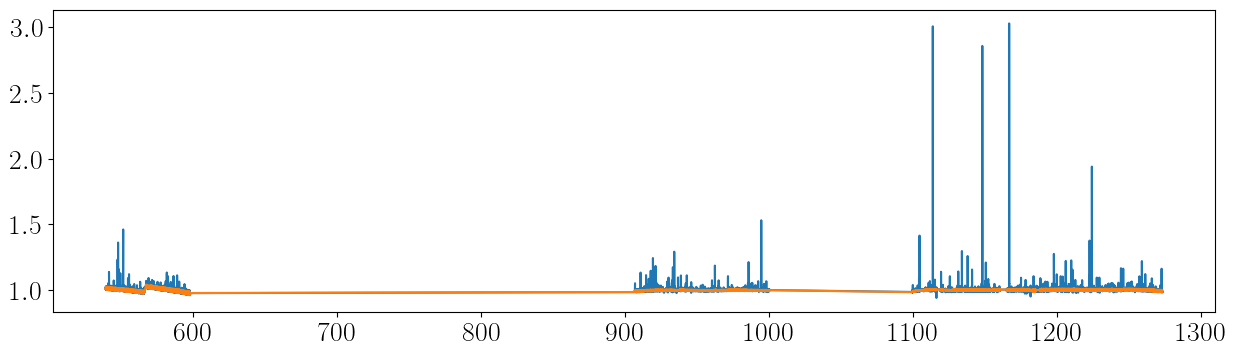

In [8]:
from glob import glob

gp_files = glob('/Users/lupitatovar/local_flares/notebooks/*11mo*.csv')

for k in range(len(gp_files)): 
    df_tmp = pd.read_csv(gp_files[k]) 
    print(k, df_tmp.shape) 
    if k==0: 
        df = df_tmp 
    else: 
         df = df.append(df_tmp) 

df = df.sort_values(by='time')

plt.figure(figsize=(15,4))
plt.plot(df['time'], df['detrended_flux'])
plt.plot(df['time'], df['mean'])
plt.show()

TESS 

0 (18522, 7)
1 (17848, 7)
2 (18322, 7)


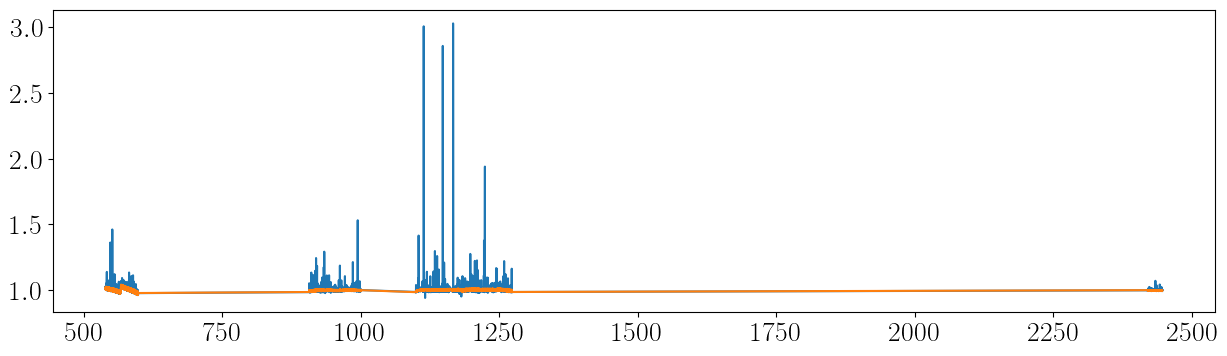

In [55]:
tess_gp_files = glob('/Users/lupitatovar/local_flares/notebooks/*tess_gp*.csv')

for k in range(len(tess_gp_files)): 
    df_tmp_t = pd.read_csv(tess_gp_files[k]) 
    print(k, df_tmp_t.shape) 
    if k==0: 
        df_t = df_tmp_t 
    else: 
         df_t = df.append(df_tmp_t) 

df_t = df_t.sort_values(by='time')

plt.figure(figsize=(15,4))
plt.plot(df_t['time'], df_t['detrended_flux'])
plt.plot(df_t['time'], df_t['mean'])
plt.show()

In [11]:
df_t

,Unnamed: 0,time,mean,std,var,detrended_flux,df_flux_err
0,0,539.460097,1.011202,0.000224,4.999456e-08,1.013348,0.000350
1,1,539.460779,1.011067,0.000205,4.213541e-08,1.011877,0.000350
2,2,539.461460,1.010932,0.000189,3.568156e-08,1.011497,0.000350
3,3,539.462141,1.010796,0.000175,3.046917e-08,1.010790,0.000350
4,4,539.462822,1.010661,0.000162,2.633292e-08,1.010560,0.000350
...,...,...,...,...,...,...,...
18317,18317,2446.575441,1.000382,0.000411,1.685660e-07,0.999498,0.001282
18318,18318,2446.576830,1.000341,0.000424,1.796651e-07,0.999876,0.001282
18319,18319,2446.578219,1.000302,0.000438,1.917277e-07,1.000922,0.001282
18320,18320,2446.579608,1.000264,0.000453,2.047762e-07,1.000394,0.001282


In [10]:
import sys  
sys.path.append('/Users/lupitatovar/Llamaradas-Estelares/') #Edit this to your own file path
from Flare_model import flare_model

Identifying the Kepler Flare peaks by taking lightcurve - gp within each flare and finding the peak flux

In [12]:
#detrended lightcurve (flux values)
detrended_kepler = df['detrended_flux'].values - df['mean'].values

In [17]:
max(detrended_kepler)

2.024291980117108

In [14]:
kepler_errors = np.sqrt((df['df_flux_err'].values)**2 + (df['std'].values) )

In [15]:
print(kepler_errors)

[0.01495718 0.01433149 0.01374838 ... 0.01355633 0.01407975 0.01463597]


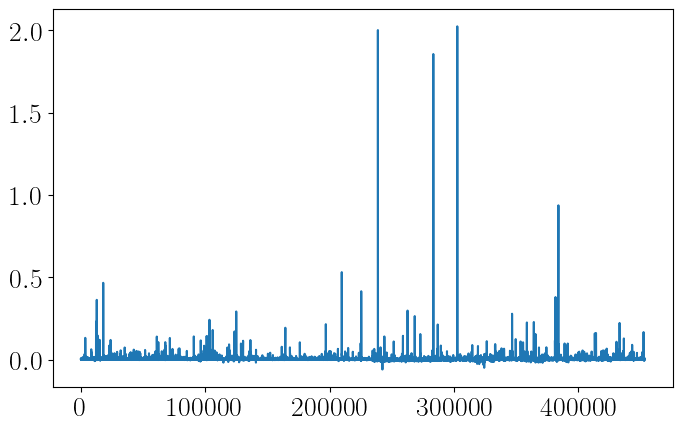

In [16]:
plt.plot(detrended_kepler)

Loop that identifies the peaks of flares within the detrended light curve

In [23]:
kep_amps = []
for i in range (0,len(flare_table)):

    #Defining times of each flare event
    i_temp = np.where((df['time'].values <= (t_stops[i]+0.01)) & 
                    (df['time'].values >= (t_starts[i]-0.005)))[0]
    
    #time where the peak flux occurs
    kep_peak_time = t_stops - t_starts #start+stop /2
    
    #peak flux amplitude
    kep_amp = max(detrended_kepler[i_temp])
    
    kep_amps=np.append(kep_amps,kep_amp)

In [24]:
len(kep_amps)

6107

In [26]:
print(kep_amps[0])
print(flare_table['flux peak'][0])

0.0018404994019221022
0.0014693


In [52]:
print(max(detrended_tess))
print(max(detrended_kepler))

2.024291980117108
2.024291980117108


Now for tess

In [69]:
tess_t_starts = full_tess.loc[:,'t_start'].values
tess_t_stops = full_tess.loc[:,'t_stop'].values

In [56]:
#detrended lightcurve (flux values)
detrended_tess = df_t['detrended_flux'].values - df_t['mean'].values
tess_errors = np.sqrt((df_t['df_flux_err'].values)**2 + (df_t['std'].values) )

In [66]:
np.where((df_t['time'].values <= (full_tess['t_stop'].values[i]+0.01)) & 
                    (df_t['time'].values >= (full_tess['t_start'].values[i]-0.005)))[0]

array([], dtype=int64)

In [71]:
tess_amps = []
for i in range (0,len(full_tess)):

    #Defining times of each flare event
    
    i_temp2 = np.where((df_t['time'].values <= (tess_t_stops[i]+0.01)) & 
                    (df_t['time'].values >= (tess_t_starts[i]-0.005)))[0]
    
    #time where the peak flux occurs
    #tess_peak_time = full_tess['t_stop'].values - full_tess['t_start'].values #start+stop /2
    
    #peak flux amplitude
    tess_amp = max(detrended_tess[i_temp2])
    
    tess_amps=np.append(tess_amps,tess_amp)

ValueError: max() arg is an empty sequence

Saving list of identified amps

In [72]:
print(len(kep_amps))
print(len(df['time'].values))
print(len(detrended_kepler))
print(len(kepler_errors))

6107
453111
453111
453111


In [73]:
k_array = [df['time'].values,detrended_kepler,kepler_errors,kep_amps]

In [76]:
kepler_new_amps = pd.DataFrame({'Amps':kep_amps})

In [78]:
#kepler_new_amps.to_csv('kepler_new_amps.csv')